In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import json
import time

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import torch

import pathlib

import config as cfg

from tokenizer.tokenizer import ByteLevelBPE, TokenizerHF

import importlib

from model.CPTR_upd import CPTR

from model.helpers import *

from dataset.loader import DatasetLoader

import copy

from save_results import save_results_smart, list_saved_configs

/home/nad/studies/Transformer-Image-Captioning-IIW/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(cfg)
torch.cuda.empty_cache()

In [5]:
config = cfg.make_config()

In [6]:
batch_size_train = config["BATCH_SIZE_TRAIN"]
batch_size_test = config["BATCH_SIZE_TEST"]

H = config["IMG_HEIGHT"]
W = config["IMG_WIDTH"]
P = config["PATCH_SIZE"]
D_IMG = config["IMG_EMBEDDING_DIM"]

# The data will get truncated/padded to this length AFTER tokenization
L = config["MAX_TEXT_SEQUENCE_LENGTH"]
D_TEXT = config["TEXT_EMBEDDING_DIM"]
DROPOUT_DEC = config["DECODER_DROPOUT_PROB"]
RANDOM_SEED = config["RANDOM_SEED"]

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(42)

## Build Dataset

In [8]:
data_loader = DatasetLoader(dataset_type=config["DATASET"],
                            img_height=H,
                            img_width=W,
                            batch_size_train=batch_size_train, 
                            batch_size_test=batch_size_test,
                            split_ratio=config["SPLIT_RATIO"],
                            shuffle_test=True,
                            seed=RANDOM_SEED)
data_loader.load_data()

train_dataloader = data_loader.get_train_dataloader()
test_dataloader = data_loader.get_test_dataloader()

Loading Flickr30k dataset...
DatasetDict({
    test: Dataset({
        features: ['image', 'description'],
        num_rows: 31014
    })
})


Number of training samples: 24811
Number of test samples: 6203
torch.Size([32, 3, 224, 224])
Caption: A woman is playing for the USA volleyball team, spiking the ball over the net.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.37856

torch.Size([32, 3, 224, 224])
Caption: Two young girls wearing denim dresses playing near a armchair.
torch.Size([32, 3, 224, 224])
Caption: A small child in a pink sweater begins to climb a concrete staircase.
torch.Size([32, 3, 224, 224])
Caption: A group of Asian soldiers dressed in traditional soldier equipment march along side soldiers atop elephants.
torch.Size([32, 3, 224, 224])
Caption: A young boy raises his head out of the pool water and takes a huge gulp of air during swimming lessons.
torch.Size([32, 3, 224, 224])
Caption: A bald man dribbles a basketball while wearing a Miami jersey.
torch.Size([32, 3, 224, 224])
Caption: Surrounded by tents, two women wearing bikinis and a man in a swim trunk work together to raise a flag pole, the top of which is a large one with white background and some green, big-teethed critter on it.
torch.Size([32, 3, 224, 224])
Caption: A man in a sports jacket with longish brown hair and glasses is getting the attention of several photographers.


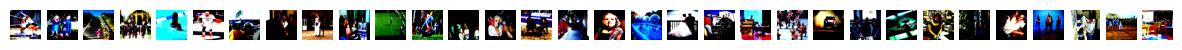

torch.Size([32, 3, 224, 224])
Caption: An elderly woman carrying a purse and a shopping bag exiting a small smart car.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clip

torch.Size([32, 3, 224, 224])
Caption: A mother and three children play on a teeter totter at a playground.
torch.Size([32, 3, 224, 224])
Caption: A man dressed in pink and white performing with his female partner dressed in pink in a dancing contest
torch.Size([32, 3, 224, 224])
Caption: A bro is skating on a rail in a skate park with not much around except green grass and concrete.
torch.Size([32, 3, 224, 224])
Caption: Two kids wearing martial arts uniforms sitting on a blue mat with two people in the background performing a stretching exercise.
torch.Size([32, 3, 224, 224])
Caption: A large crowd of people are outside and a big sign reads "AIDS WALK" in the background among trees.
torch.Size([32, 3, 224, 224])
Caption: At the amusement park, a young lady tries to win a stuffed animal by playing one of the games.
torch.Size([32, 3, 224, 224])
Caption: A woman wearing a red and pink garment is making pottery out of clay on the ground with no shoes on.
torch.Size([32, 3, 224, 224])
Ca

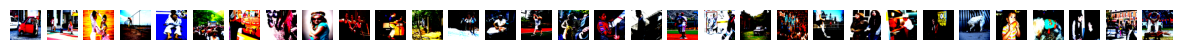

In [7]:
# dataset stats
print(f"Number of training samples: {len(train_dataloader.dataset)}")
print(f"Number of test samples: {len(test_dataloader.dataset)}")

# plot some samples from the dataset
data_iter = iter(test_dataloader)
batch = next(data_iter)
image_tensor = batch['pixel_values']
captions = batch['description']
fig, axs = plt.subplots(1, batch_size_test, figsize=(15, 5))
for i in range(batch_size_test):
    print(image_tensor.shape)
    img = image_tensor[i].cpu().permute(1, 2, 0).numpy()
    print('Caption:', captions[i])
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

data_iter = iter(train_dataloader)
batch = next(data_iter)
image_tensor = batch['pixel_values']
captions = batch['description']
fig, axs = plt.subplots(1, batch_size_train, figsize=(15, 5))
for i in range(batch_size_train):
    print(image_tensor.shape)
    img = image_tensor[i].cpu().permute(1, 2, 0).numpy()
    print('Caption:', captions[i])
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

## Initialize Tokenizer

In [9]:
special_tokens = [cfg.SpecialTokens.PAD, cfg.SpecialTokens.BOS, cfg.SpecialTokens.EOS]
if config["TOKENIZER_TYPE"] == cfg.TokenizerType.HF:
    tokenizer = TokenizerHF()
elif config["TOKENIZER_TYPE"] == cfg.TokenizerType.BPE:
    tokenizer = ByteLevelBPE(special_tokens=special_tokens)
    tokenizer.load(folder=config["TOKENIZER_DATA_PATH"], filename_prefix=config["TOKENIZER_FILENAME_PREFIX"])
    
pad_idx = tokenizer.get_padding_token_id()
vocab_size = tokenizer.get_vocab_size()
print(f"Tokenizer vocab size: {vocab_size}, Pad token ID: {pad_idx}")

Tokenizer vocab size: 10042, Pad token ID: 0


## Configure Model

In [9]:
transformer = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)

Initialized CNN ResNet-50 Encoder


## Training code

In [10]:
class EarlyStopping:
    def __init__(self, patience, delta, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
        self.best_model_state = None
    
    def check_early_stop(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
            self.best_model_state = copy.deepcopy(model.state_dict())
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
                if self.verbose:
                    print("Stopping early as no improvement has been observed.")

In [11]:
def train_step(model: torch.nn.Module,
               config,
               dataloader: torch.utils.data.DataLoader,
               tokenizer,
               pad_idx: int,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch in dataloader:
        images = batch["pixel_values"].to(device)
        texts = batch["description"]

        outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
        tokens = outputs['input_ids']
        tokens = tokens.to(device)

        targets = tokens[:, 1:]
        decoder_inputs = tokens[:, :-1]
        T = decoder_inputs.size(1)
        attention_mask = get_causal_mask(T, device=device)
        padding_mask = get_padding_mask(decoder_inputs, pad_idx, device=device)

        logits, loss = model(images=images, text_tokens=decoder_inputs, attn_mask=attention_mask, pad_mask=padding_mask, targets=targets)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients to a max norm of 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            pad_idx = tokenizer.get_padding_token_id()
            non_pad = targets != pad_idx
            acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
            train_acc += acc.item()
        
        if verbose:
            with torch.no_grad():
                # print produced tokens for debugging
                if epoch is not None and config.NUM_EPOCHS - epoch <= 1:  # print only for last 2 epochs
                    decoded_preds = tokenizer.decode_batched(preds) #[tokenizer.decode(preds[i].cpu().numpy()) for i in range(preds.size(0))]
                    decoded_targets = tokenizer.decode_batched(targets) #[tokenizer.decode(targets[i].cpu().numpy()) for i in range(targets.size(0))]
                    for dp, dt in zip(decoded_preds, decoded_targets):
                        print(f"Predicted: {dp} | Target: {dt}")
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_perplexity = torch.exp(torch.tensor(train_loss)).item()
    train_acc = train_acc / len(dataloader)
    return train_loss, train_perplexity, train_acc

def train_step_accumulate(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               config,
               tokenizer,
               pad_idx: int,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               accumulation_steps: int,
               device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    accumulation_steps: Number of steps to accumulate gradients before updating the model.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    model.train()
    train_loss, train_acc = 0, 0
    
    # Reset gradients at the start
    optimizer.zero_grad()

    for i, batch in enumerate(dataloader):
        images = batch["pixel_values"].to(device)
        texts = batch["description"]
        outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
        tokens = outputs['input_ids'].to(device)

        targets = tokens[:, 1:]
        decoder_inputs = tokens[:, :-1]
        T = decoder_inputs.size(1)
        
        logits, loss = model(
            images=images, 
            text_tokens=decoder_inputs, 
            attn_mask=get_causal_mask(T, device), 
            pad_mask=get_padding_mask(decoder_inputs, pad_idx, device), 
            targets=targets
        )

        # 3. Normalize loss to account for accumulation
        loss = loss / accumulation_steps
        loss.backward()

        # 4. Optimizer Step (only every 'accumulation_steps')
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad() # Clear for next set

        train_loss += (loss.item() * accumulation_steps)

        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            pad_idx = tokenizer.get_padding_token_id()
            non_pad = targets != pad_idx
            acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
            train_acc += acc.item()
        
        if verbose:
            with torch.no_grad():
                # print produced tokens for debugging
                if epoch is not None and config.NUM_EPOCHS - epoch <= 1:  # print only for last 2 epochs
                    decoded_preds = tokenizer.decode_batched(preds) #[tokenizer.decode(preds[i].cpu().numpy()) for i in range(preds.size(0))]
                    decoded_targets = tokenizer.decode_batched(targets) #[tokenizer.decode(targets[i].cpu().numpy()) for i in range(targets.size(0))]
                    for dp, dt in zip(decoded_preds, decoded_targets):
                        print(f"Predicted: {dp} | Target: {dt}")
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_perplexity = torch.exp(torch.tensor(train_loss)).item()
    train_acc = train_acc / len(dataloader)
    return train_loss, train_perplexity, train_acc

def test_step(model: torch.nn.Module,
              config,
              dataloader: torch.utils.data.DataLoader,
              tokenizer,
              pad_idx: int,
              device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    model.eval()

    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        for batch in dataloader:
          images = batch["pixel_values"].to(device)
          texts = batch["description"]

          outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
          tokens = outputs['input_ids']
          tokens = tokens.to(device)
          tokens = tokens.to(device)

          targets = tokens[:, 1:]
          decoder_inputs = tokens[:, :-1]
          T = decoder_inputs.size(1)
          attention_mask = get_causal_mask(T, device=device)
          padding_mask = get_padding_mask(decoder_inputs, pad_idx, device=device)
        
          logits, loss = model(images=images, text_tokens=decoder_inputs, attn_mask=attention_mask, pad_mask=padding_mask, targets=targets)

          test_loss += loss.item()

          preds = logits.argmax(dim=-1)
          pad_idx = tokenizer.get_padding_token_id()
          non_pad = targets != pad_idx
          acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
          test_acc += acc.item()
          
          if verbose:
            # print produced tokens for debugging
            if epoch is not None and config["NUM_EPOCHS"] - epoch <= 1:  # print only for last 2 epochs
              decoded_preds = tokenizer.decode_batched(preds)
              decoded_targets = tokenizer.decode_batched(targets)
              for dp, dt in zip(decoded_preds, decoded_targets):
                  print(f"Predicted: {dp} | Target: {dt}")

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_perplexity = torch.exp(torch.tensor(test_loss)).item()
    test_acc = test_acc / len(dataloader)
    return test_loss, test_perplexity, test_acc

def train(model: torch.nn.Module,
          config,
          tokenizer, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          epochs: int,
          device: torch.device,
          early_stop_patience: int,
          early_stop_delta: float) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_perplexity: [...],
              train_acc: [...],
              test_loss: [...],
              test_perplexity: [...],
              test_acc: [...]} 
    """
    results = {"train_loss": [],
               "train_perplexity": [],
               "train_acc": [],
               "test_loss": [],
               "test_perplexity": [],
               "test_acc": []
    }
    
    model.to(device)
    
    pad_idx = tokenizer.get_padding_token_id()
    early_stopping = EarlyStopping(patience=early_stop_patience, delta=early_stop_delta, verbose=True)

    for epoch in tqdm(range(epochs)):
        if config["USE_ACCUMULATED_GRADIENTS"]:
            train_loss, train_perplexity, train_acc = train_step_accumulate(model=model,
                                              config=config,
                                              dataloader=train_dataloader,
                                              tokenizer=tokenizer,
                                              pad_idx=pad_idx,
                                              optimizer=optimizer,
                                              scheduler=scheduler,
                                              accumulation_steps=config["ACCUMULATION_STEPS"],
                                              device=device,
                                              epoch=epoch)
        else:
          train_loss, train_perplexity, train_acc = train_step(model=model,
                                            config=config,
                                            dataloader=train_dataloader,
                                            tokenizer=tokenizer,
                                            pad_idx=pad_idx,
                                            optimizer=optimizer,
                                            scheduler=scheduler,
                                            device=device,
                                            epoch=epoch)
        test_loss, test_perplexity, test_acc = test_step(model=model,
                                                         config=config,
                                                         dataloader=test_dataloader,
                                                         tokenizer=tokenizer,
                                                         pad_idx=pad_idx,
                                                         device=device,
                                                         epoch=epoch)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_perplexity: {train_perplexity:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_perplexity: {test_perplexity:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_perplexity"].append(train_perplexity)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_perplexity"].append(test_perplexity)
        results["test_acc"].append(test_acc)

        early_stopping.check_early_stop(test_loss, model)
        if early_stopping.stop_training:
            model.load_state_dict(early_stopping.best_model_state)
            break
    
    return results

In [12]:
# freeze/unfreeze encoder weights
def config_encoder_params(model, requires_grad: bool):
    if config["ENCODER_ARCH"] == cfg.EncoderArch.CNN_RESNET50:
        if requires_grad == True:
            for layer in model.encoder.backbone[-2:]:  # unfreeze last 2 residual blocks
                for param in layer.parameters():
                    param.requires_grad = True
        else:
            for param in model.encoder.parameters():
                param.requires_grad = False
                
    elif config["ENCODER_ARCH"] == cfg.EncoderArch.VIT_STYLE_BASE or config["ENCODER_ARCH"] == cfg.EncoderArch.VIT_STYLE_LARGE:
        if requires_grad == True:
            for layer in model.encoder.vit.encoder.layer[-3:]:  # unfreeze last 3 transformer blocks
                for param in layer.parameters():
                    param.requires_grad = True
        else:
            for param in model.encoder.parameters():
                param.requires_grad = False
                
    elif config["ENCODER_ARCH"] == cfg.EncoderArch.CNN_CPTR_STYLE:
        if requires_grad == True:
            for layer in model.encoder.patcher.backbone[-2:]:  # unfreeze last 2 residual blocks
                for param in layer.parameters():
                    param.requires_grad = True
        else:
            for param in model.encoder.patcher.parameters():
                param.requires_grad = False
                
    else:
        for param in model.encoder.parameters():
            param.requires_grad = requires_grad

In [13]:
if config["NUM_FREEZE_EPOCHS"] > 0:
    config_encoder_params(transformer, requires_grad=False)
    
    optimizer = torch.optim.AdamW(
        [p for p in transformer.parameters() if p.requires_grad],
        lr=config["LR"],
        weight_decay=0.01
    )
    
    if config["USE_ACCUMULATED_GRADIENTS"]:
        effective_steps_per_epoch = len(train_dataloader) // config["ACCUMULATION_STEPS"]
        # Account for the possible partial batch at the end
        if len(train_dataloader) % config["ACCUMULATION_STEPS"] != 0:
            effective_steps_per_epoch += 1
    else:
        effective_steps_per_epoch = len(train_dataloader)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["LR"], 
        steps_per_epoch=effective_steps_per_epoch, 
        epochs=config["NUM_FREEZE_EPOCHS"],
        pct_start=0.1 # 10% of time spent warming up
    )

In [14]:
# Check which parameters require gradients
params_with_grad = {name: param for name, param in transformer.named_parameters() if param.requires_grad}
print("Parameters requiring gradients:")
for name, param in params_with_grad.items():
    print(f"{name}: {param.shape}")

Parameters requiring gradients:
emb_projector.projection.weight: torch.Size([512, 2048])
emb_projector.projection.bias: torch.Size([512])
emb_projector.layernorm.weight: torch.Size([512])
emb_projector.layernorm.bias: torch.Size([512])
decoder.word_embedding.embedding.weight: torch.Size([10042, 512])
decoder.text_layernorm.weight: torch.Size([512])
decoder.text_layernorm.bias: torch.Size([512])
decoder.decoder_blocks.0.MMHSA.in_proj_weight: torch.Size([1536, 512])
decoder.decoder_blocks.0.MMHSA.in_proj_bias: torch.Size([1536])
decoder.decoder_blocks.0.MMHSA.out_proj.weight: torch.Size([512, 512])
decoder.decoder_blocks.0.MMHSA.out_proj.bias: torch.Size([512])
decoder.decoder_blocks.0.layer_norm_1.weight: torch.Size([512])
decoder.decoder_blocks.0.layer_norm_1.bias: torch.Size([512])
decoder.decoder_blocks.0.MHCA.in_proj_weight: torch.Size([1536, 512])
decoder.decoder_blocks.0.MHCA.in_proj_bias: torch.Size([1536])
decoder.decoder_blocks.0.MHCA.out_proj.weight: torch.Size([512, 512])
dec

In [15]:
if config["NUM_FREEZE_EPOCHS"] > 0:
    # Train the model for freezing phase
    results = train(model=transformer,
                    config=config,
                    tokenizer=tokenizer,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    epochs=config["NUM_FREEZE_EPOCHS"],
                    device=device,
                    early_stop_patience=config["EARLY_STOPPING_PATIENCE"],
                    early_stop_delta=config["EARLY_STOPPING_DELTA"])
    print('Completed freezing phase.')

  3%|▎         | 1/30 [03:37<1:45:08, 217.55s/it]

Epoch: 1 | train_loss: 7.6144 | train_perplexity: 2027.0774 | train_acc: 0.0739 | test_loss: 5.0418 | test_perplexity: 154.7423 | test_acc: 0.1618


  7%|▋         | 2/30 [07:55<1:52:29, 241.06s/it]

Epoch: 2 | train_loss: 4.0599 | train_perplexity: 57.9712 | train_acc: 0.2673 | test_loss: 3.3568 | test_perplexity: 28.6964 | test_acc: 0.3363


 10%|█         | 3/30 [11:31<1:43:25, 229.82s/it]

Epoch: 3 | train_loss: 3.1432 | train_perplexity: 23.1770 | train_acc: 0.3615 | test_loss: 2.9244 | test_perplexity: 18.6234 | test_acc: 0.3927


 13%|█▎        | 4/30 [15:09<1:37:35, 225.21s/it]

Epoch: 4 | train_loss: 2.8007 | train_perplexity: 16.4570 | train_acc: 0.4088 | test_loss: 2.6685 | test_perplexity: 14.4185 | test_acc: 0.4332


 17%|█▋        | 5/30 [18:46<1:32:33, 222.14s/it]

Epoch: 5 | train_loss: 2.5684 | train_perplexity: 13.0447 | train_acc: 0.4458 | test_loss: 2.5030 | test_perplexity: 12.2193 | test_acc: 0.4608


 20%|██        | 6/30 [22:23<1:28:07, 220.32s/it]

Epoch: 6 | train_loss: 2.3993 | train_perplexity: 11.0159 | train_acc: 0.4736 | test_loss: 2.3973 | test_perplexity: 10.9939 | test_acc: 0.4816


 23%|██▎       | 7/30 [25:59<1:23:59, 219.11s/it]

Epoch: 7 | train_loss: 2.2672 | train_perplexity: 9.6527 | train_acc: 0.4948 | test_loss: 2.3326 | test_perplexity: 10.3045 | test_acc: 0.4933


 27%|██▋       | 8/30 [29:36<1:20:00, 218.23s/it]

Epoch: 8 | train_loss: 2.1591 | train_perplexity: 8.6631 | train_acc: 0.5129 | test_loss: 2.2902 | test_perplexity: 9.8772 | test_acc: 0.5014


 30%|███       | 9/30 [33:13<1:16:17, 217.97s/it]

Epoch: 9 | train_loss: 2.0679 | train_perplexity: 7.9084 | train_acc: 0.5279 | test_loss: 2.2636 | test_perplexity: 9.6173 | test_acc: 0.5049


 33%|███▎      | 10/30 [36:50<1:12:32, 217.61s/it]

Epoch: 10 | train_loss: 1.9828 | train_perplexity: 7.2627 | train_acc: 0.5426 | test_loss: 2.2519 | test_perplexity: 9.5061 | test_acc: 0.5101


 37%|███▋      | 11/30 [40:27<1:08:49, 217.37s/it]

Epoch: 11 | train_loss: 1.9055 | train_perplexity: 6.7228 | train_acc: 0.5561 | test_loss: 2.2514 | test_perplexity: 9.5007 | test_acc: 0.5126


 40%|████      | 12/30 [44:04<1:05:13, 217.44s/it]

Epoch: 12 | train_loss: 1.8346 | train_perplexity: 6.2628 | train_acc: 0.5685 | test_loss: 2.2547 | test_perplexity: 9.5323 | test_acc: 0.5135


 40%|████      | 12/30 [47:41<1:11:31, 238.42s/it]

Epoch: 13 | train_loss: 1.7696 | train_perplexity: 5.8684 | train_acc: 0.5803 | test_loss: 2.2639 | test_perplexity: 9.6207 | test_acc: 0.5149
Stopping early as no improvement has been observed.
Completed freezing phase.


In [16]:
config_encoder_params(transformer, requires_grad=True)

optimizer = torch.optim.AdamW(
    [
        {
            'params': [p for n, p in transformer.named_parameters() if "encoder" not in n],
            'lr': config["LR"]
        },
        {
            'params': [p for n, p in transformer.named_parameters() if "encoder" in n],
            'lr': config["LR"] * 0.01
        }
    ],
    weight_decay=config["WEIGHT_DECAY"]
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config["NUM_EPOCHS"],
    eta_min=1e-7
)

In [17]:
# Recheck which parameters require gradients
params_with_grad = {name: param for name, param in transformer.named_parameters() if param.requires_grad}
print("Parameters requiring gradients:")
for name, param in params_with_grad.items():
    print(f"{name}: {param.shape}")

Parameters requiring gradients:
encoder.backbone.6.0.conv1.weight: torch.Size([256, 512, 1, 1])
encoder.backbone.6.0.bn1.weight: torch.Size([256])
encoder.backbone.6.0.bn1.bias: torch.Size([256])
encoder.backbone.6.0.conv2.weight: torch.Size([256, 256, 3, 3])
encoder.backbone.6.0.bn2.weight: torch.Size([256])
encoder.backbone.6.0.bn2.bias: torch.Size([256])
encoder.backbone.6.0.conv3.weight: torch.Size([1024, 256, 1, 1])
encoder.backbone.6.0.bn3.weight: torch.Size([1024])
encoder.backbone.6.0.bn3.bias: torch.Size([1024])
encoder.backbone.6.0.downsample.0.weight: torch.Size([1024, 512, 1, 1])
encoder.backbone.6.0.downsample.1.weight: torch.Size([1024])
encoder.backbone.6.0.downsample.1.bias: torch.Size([1024])
encoder.backbone.6.1.conv1.weight: torch.Size([256, 1024, 1, 1])
encoder.backbone.6.1.bn1.weight: torch.Size([256])
encoder.backbone.6.1.bn1.bias: torch.Size([256])
encoder.backbone.6.1.conv2.weight: torch.Size([256, 256, 3, 3])
encoder.backbone.6.1.bn2.weight: torch.Size([256])
e

In [18]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [19]:
# Train the model for the rest of the epochs and save the training results to a dictionary
results = train(model=transformer,
                config=config,
                tokenizer=tokenizer,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                epochs=config["NUM_EPOCHS"],
                device=device,
                early_stop_patience=int(config["NUM_EPOCHS"]*0.1),
                early_stop_delta=config["EARLY_STOPPING_DELTA"])
print('Completed training.')

  5%|▌         | 1/20 [04:10<1:19:26, 250.86s/it]

Epoch: 1 | train_loss: 1.8906 | train_perplexity: 6.6233 | train_acc: 0.5590 | test_loss: 2.2509 | test_perplexity: 9.4965 | test_acc: 0.5143


 10%|█         | 2/20 [08:21<1:15:15, 250.85s/it]

Epoch: 2 | train_loss: 1.8392 | train_perplexity: 6.2913 | train_acc: 0.5687 | test_loss: 2.2539 | test_perplexity: 9.5250 | test_acc: 0.5145


 10%|█         | 2/20 [12:33<1:52:59, 376.65s/it]

Epoch: 3 | train_loss: 1.8003 | train_perplexity: 6.0516 | train_acc: 0.5751 | test_loss: 2.2624 | test_perplexity: 9.6066 | test_acc: 0.5141
Stopping early as no improvement has been observed.
Completed training.


In [20]:
success, message, target_folder_name = save_results_smart(model=transformer, results=results, current_config=config)

if success:
    print("✓ Results saved successfully!")
    print(message)
else:
    print("✗ Results not saved:")
    print(message)

Current test loss: 2.262448452182652
Searching for matching configuration folder...
  - Checking folder: config_20260121-041202
    Comparing DATASET: 'flickr' vs 'flickr'
    Comparing ENCODER_ARCH: 'resnet50' vs 'resnet50'
    Comparing TOKENIZER_TYPE: 'bpe' vs 'bpe'
    -> Match found: config_20260121-041202
Existing test loss: 3.2936133711608413
✓ Results saved successfully!
Overwriting results in matching config folder: config_20260121-041202
  - Model saved: cptr_model.pth
  - Results saved: training_results.json
  - Config saved: config.json


In [ ]:
config = cfg.import_config(pathlib.Path(target_folder_name) / 'config.json', override=False)
model_path = pathlib.Path(target_folder_name) / 'cptr_model.pth'

## Test caption generation

In [13]:
transformer = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)
transformer.load_state_dict(torch.load(model_path, map_location=device))

Initialized CNN ResNet-50 Encoder


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.3611329].


Caption GT:  A brown dog is chasing a black dog through the snow in front of a wire mesh fence.
Input image shape: torch.Size([1, 3, 224, 224])


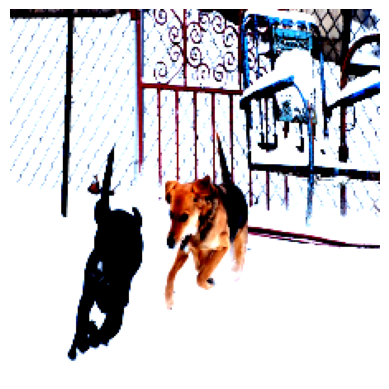

Generated token ids: tensor([  1,  68, 398, 297, 552, 270, 275, 522, 291, 259, 333, 398, 270, 275,
        389, 106, 280, 340,  49,   2])
torch.Size([20])
Generated caption: <bos>A dog is running in the snow with a black dog in the background.<eos>


In [ ]:
transformer.eval()

batch = next(iter(test_dataloader))
image = batch["pixel_values"][0].unsqueeze(0).to(device)
print('Caption GT: ', batch["description"][0])
print('Input image shape:', image.shape)
# plot input image
img = image[0].cpu().permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()

tokens = transformer.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
print('Generated token ids:', tokens)
print(tokens.shape)
decoded_caption = tokenizer.decode(tokens)
print('Generated caption:', decoded_caption)